# Creating WTs with SNIP

This notebook contains code for:
- importing necessary libraries
- dowloading and preprocessing the datasets
- using the datasets to train the full model and save the accuracies
- performing SNIP using the model and datset
- saving sparse model weights of WTs in Folder

In [1]:
# importing necessary libraries and the cnn architecture I defined

from cnn_architecture import CNN2Model
from utils import *
from load_datasets import load_and_prep_dataset

import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.io import loadmat
import copy

In [2]:
# modified train loop to also work with sparse networks (such that pruned weights remain frozen at 0.0)

def train_loop_sparse(train, test, model, num_epochs=5):
    
    # hyperparameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    
    # initializing training statistics
    train_accuracy = tf.keras.metrics.Accuracy(name='test_accuracy')
    test_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
    train_losses = tf.keras.metrics.CategoricalCrossentropy(name='train_losses')
    test_losses = tf.keras.metrics.CategoricalCrossentropy(name='test_losses')
    train_acc = []
    test_acc = []
    train_l =[]
    test_l = []

    for epoch in tqdm(range(num_epochs), leave=False, desc="training epochs"):
        
        #train step
        for x, t in train:
            with tf.GradientTape() as tape:
                pred = model(x)
                loss = loss_function(t, pred)
                train_losses.update_state(t, pred)
                train_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            gradients = tape.gradient(loss, model.trainable_variables)
            
            # set gradients to zero for all pruned weights
            new_gradients = []
            for gradient_matrix, variables in zip(gradients, model.trainable_variables):
                gradient_matrix = tf.where(variables == 0.0, 0.0, gradient_matrix)
                new_gradients.append(gradient_matrix)
            optimizer.apply_gradients(zip(new_gradients, model.trainable_variables))
            
        # test step
        for x, t in test:
            pred = model(x)
            test_accuracy.update_state(tf.argmax(t,1), tf.argmax(pred,1))
            test_losses.update_state(t, pred)
        
        # updataing training statistics
        train_acc.append(train_accuracy.result().numpy())
        test_acc.append(test_accuracy.result().numpy())
        train_l.append(train_losses.result().numpy())
        test_l.append(test_losses.result().numpy())
        train_accuracy.reset_state()
        test_accuracy.reset_state()
        train_losses.reset_state()
        test_losses.reset_state()
        
    # collect statistics in a dictionary
    losses = { "test loss":test_l , "training loss":train_l , "test accuracy":test_acc , "training accuracy":train_acc}
    
    return  losses

In [3]:
# pruning a model via snip pruning criterion

def snip(datasetname, model, pruning_rate_conv=0.6794931592039801, pruning_rate_dense=0.9176456925675676, pruning_batch_size = 512):
    
    # get data batch
    train_dataset, test_dataset = load_and_prep_dataset(datasetname, batch_size=pruning_batch_size, shuffle_size=pruning_batch_size*4)
    
    # get gradients
    loss_function= tf.keras.losses.CategoricalCrossentropy()
    gradients = None
    for x, t in train_dataset:
        with tf.GradientTape() as tape:
            pred = model(x)
            loss = loss_function(t, pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        break
    
    
    # calculate and collect pruning scores
    scores_all = []
    for layer, gradients in zip(model.get_weights()[::2], gradients[::2]):
        scores_layer = np.abs(layer * gradients)
        scores_all.append(copy.copy(scores_layer))
        
    #######################
    # pruning conv layers #
    #######################
    
    new_layers = []
    for layer, scores_layer in zip(model.get_weights()[0:4:2], scores_all[:2]):
        conv_percentile = np.percentile(scores_layer, pruning_rate_conv * 100)
        new_layer = tf.where(scores_layer < conv_percentile, 0.0, layer)
        new_layers.append(new_layer)
        
    ########################
    # pruning dense layers #
    ########################
    
    dense_percentile = np.percentile(get_flat(scores_all[2:]), pruning_rate_dense * 100)
    
    for layer, scores_layer in zip(model.get_weights()[4::2], scores_all[2:]):
        new_layer = tf.where(scores_layer < dense_percentile, 0.0, layer)
        new_layers.append(new_layer)
    
    #################################################
    # putting the pruned layers back into the model #
    #################################################
        
    # set new model weights
    new_weights = model.get_weights()
    new_weights[::2] = new_layers
    model.set_weights(new_weights)
    
    return model

In [4]:
def create_sparse_net(datasetname, train_dataset, test_dataset):
    
    #########################################
    # 1.:  get initial weight configuration #
    #########################################

    model = CNN2Model()

    #predict something with the model so it initializes the weights
    model(list(train_dataset)[0][0])

    #save the initial weights
    initial_weights = model.get_weights()
        
    #########################################################################
    # 2.:  train control model with initial weights to get control accuracy #
    #########################################################################

    control_model = CNN2Model()
    control_model(list(train_dataset)[0][0])
    control_model.set_weights(initial_weights)

    control_losses = train_loop_sparse(train_dataset, test_dataset, control_model)
    plot_losses(datasetname, "Control", control_losses ,"CNN Loss and Accuracy for control model")
    
    #########################################################
    # 3.:  use initial weights to also perform SNIP pruning #
    #########################################################

    snip_model = CNN2Model()
    snip_model(list(train_dataset)[0][0])
    snip_model.set_weights(initial_weights)
    
    snip_model = snip(datasetname, snip_model)
    
    #get resulting sparse network weights
    sparse_weights = snip_model.get_weights()
    
    ##############################################################
    # 4.:  train the resulting sparse network and get accuracies #
    ##############################################################
    
    snip_losses = train_loop_sparse(train_dataset, test_dataset, snip_model)
    plot_losses(datasetname, "SNIP", snip_losses,"CNN Loss and Accuracy for snip pruned model")
    
    return control_losses, snip_losses, sparse_weights

In [5]:
def create_lottery_tickets(runs, dataset):

    train_dataset, test_dataset = load_and_prep_dataset(dataset, batch_size=60, shuffle_size=512)    
    
    for r in range(runs):
        
        # create sparse network
        control_losses, snip_losses, sparse_weights = create_sparse_net(dataset, train_dataset, test_dataset)
        control_accuracy = np.max(control_losses["test accuracy"])
        sparse_accuracy = np.max(snip_losses["test accuracy"])
        print("Best accuracy of control model: ", control_accuracy)
        print("Best accuracy of sparse model: ", sparse_accuracy)
        
        # calculate percentage of pruned weights
        print("total pruning rate:", get_pruning_rate(sparse_weights))
        print("layerwise pruning rates:", get_pruning_rates(sparse_weights))
        
        # compare accuracy to check wheter sparse network is winning ticket
        if sparse_accuracy + 0.02 >= control_accuracy:
            print("It's a winning ticket!")
            
            # save WT model weights
            sparse_model = CNN2Model()
            sparse_model(list(train_dataset)[0][0])
            sparse_model.set_weights(sparse_weights)
            sparse_model.save_weights(f"./1b WTs/WT_{dataset}_SNIP_{r}", save_format="h5", overwrite=True)
            
        else:
            print("It's not a winning ticket.")

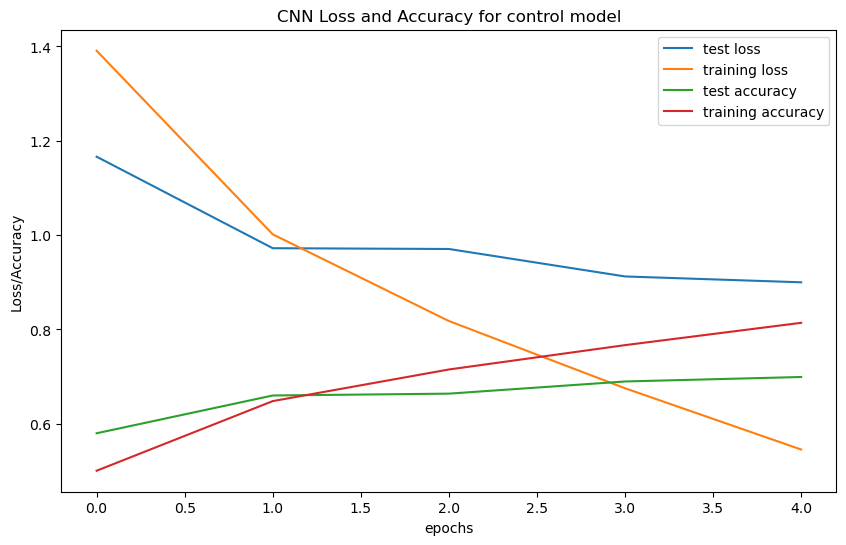

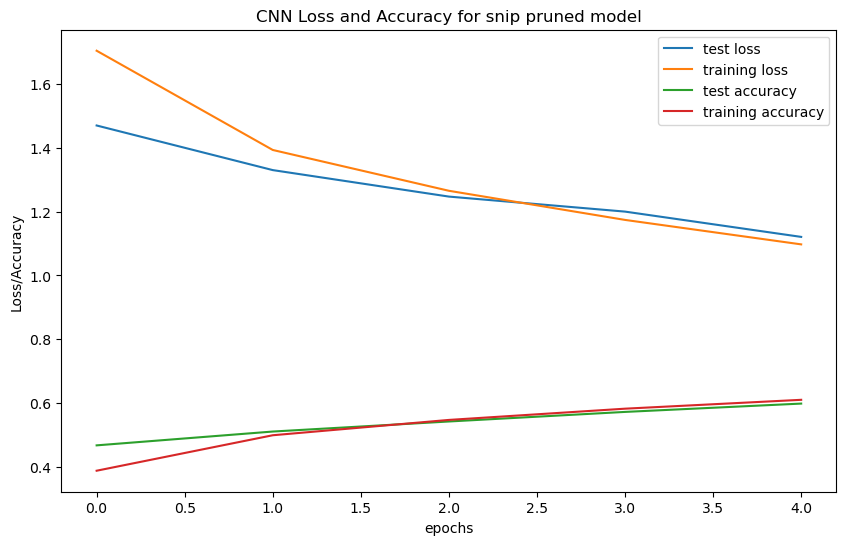

Best accuracy of control model:  0.6991
Best accuracy of sparse model:  0.5987
total pruning rate: 0.9153704562118372
layerwise pruning rates: [0.6793981481481481, 0.0, 0.6794976128472222, 0.0, 0.9238255023956299, 0.0, 0.549468994140625, 0.0, 0.21796875000000004, 0.0]
It's not a winning ticket.


In [6]:
create_lottery_tickets(1, "CIFAR")

In [7]:
pruning_rates = [0.6799768518518519, 0.0, 0.6794704861111112, 0.0, 0.9276461601257324, 0.0, 0.3068695068359375, 0.0, 0.16874999999999996, 0.0]